In [1]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [2]:
#torch.cuda.empty_cache()

# Logger

In [3]:
log_path = 'results_v3/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. Trying to reduce it: v1. 255 Normalization. Weighted for Precision.')

# Config

In [4]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [5]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [6]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [7]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [8]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

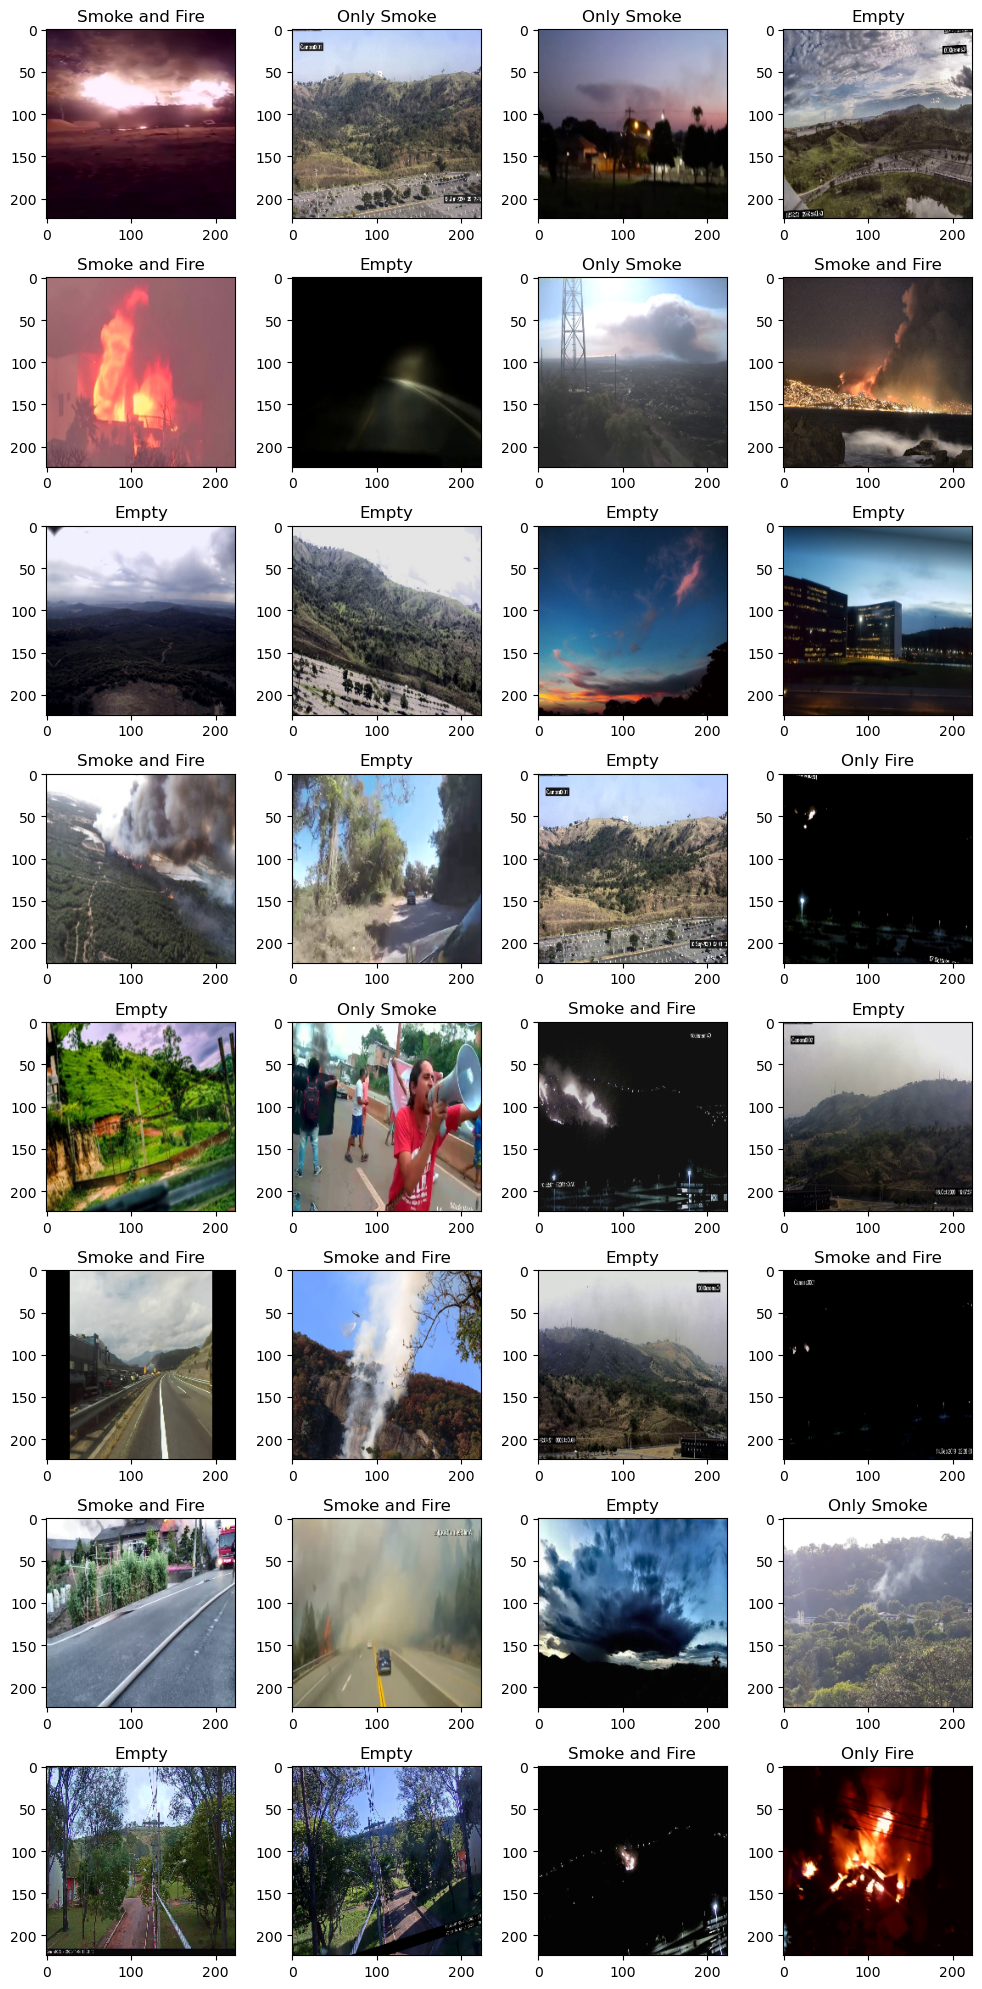

In [9]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [10]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [11]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [12]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
EPOCHS = 125 #100
NUM_WORKERS = 8
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [13]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [14]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [15]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [16]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [17]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[-0.0280,  0.0150],
        [ 0.0933, -0.0303],
        [-0.0212, -0.1215],
        [ 0.1785,  0.0264]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [18]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [19]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 10:47:11

Initializing Weights

=== EPOCH 0/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.393      |36.594      |31.799      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.971      |36.066      |24.905      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.718 - Recall: 0.401 - Accuracy: 0.804 - F1: 0.514

Saving model with new best validation loss: 60.971

=== EPOCH 1/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.722      |35.620      |26.101      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.976      |34.840      |21.136      

SMOKE -> Precision: 0.725 - Recall: 0.083 - Accuracy: 0.544 - F1: 0.149
FIRE -> Precision: 0.724 - Recall: 0.672 - Accuracy: 0.849 - F1: 0.697

Saving model with new best validation loss: 55.976

=== EPOCH 2/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.990      |35.030      |23.960      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.563      |34.254      |21.309      

SMOKE -> Precision: 0.747 - Recall: 0.210 - Accuracy: 0.586 - F1: 0.328
FIRE -> Precision: 0.721 - Recall: 0.702 - Accuracy: 0.853 - F1: 0.711

Saving model with new best validation loss: 55.563

=== EPOCH 3/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
56.938      |34.679      |22.259      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.780      |33.402      |18.378      

SMOKE -> Precision: 0.756 - Recall: 0.219 - Accuracy: 0.590 - F1: 0.340
FIRE -> Precision: 0.782 - Recall: 0.708 - Accuracy: 0.873 - F1: 0.743

Saving model with new best validation loss: 51.780

=== EPOCH 4/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
54.646      |33.895      |20.751      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.695      |32.548      |17.148      

SMOKE -> Precision: 0.794 - Recall: 0.324 - Accuracy: 0.634 - F1: 0.460
FIRE -> Precision: 0.801 - Recall: 0.738 - Accuracy: 0.885 - F1: 0.768

Saving model with new best validation loss: 49.695

=== EPOCH 5/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.016      |33.296      |19.721      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.953      |31.710      |17.243      

SMOKE -> Precision: 0.792 - Recall: 0.414 - Accuracy: 0.666 - F1: 0.544
FIRE -> Precision: 0.865 - Recall: 0.701 - Accuracy: 0.894 - F1: 0.775

Saving model with new best validation loss: 48.953

=== EPOCH 6/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.111      |32.392      |18.719      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.027      |30.172      |15.854      

SMOKE -> Precision: 0.795 - Recall: 0.425 - Accuracy: 0.670 - F1: 0.554
FIRE -> Precision: 0.777 - Recall: 0.852 - Accuracy: 0.899 - F1: 0.813

Saving model with new best validation loss: 46.027

=== EPOCH 7/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.213      |31.346      |17.868      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.888      |28.431      |14.458      

SMOKE -> Precision: 0.771 - Recall: 0.603 - Accuracy: 0.723 - F1: 0.677
FIRE -> Precision: 0.827 - Recall: 0.833 - Accuracy: 0.912 - F1: 0.830

Saving model with new best validation loss: 42.888

=== EPOCH 8/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.262      |30.821      |17.440      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 21.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.235      |27.699      |13.536      

SMOKE -> Precision: 0.802 - Recall: 0.588 - Accuracy: 0.732 - F1: 0.679
FIRE -> Precision: 0.867 - Recall: 0.823 - Accuracy: 0.921 - F1: 0.844

Saving model with new best validation loss: 41.235

=== EPOCH 9/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.316      |30.381      |16.935      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.248      |27.056      |13.191      

SMOKE -> Precision: 0.828 - Recall: 0.514 - Accuracy: 0.715 - F1: 0.634
FIRE -> Precision: 0.826 - Recall: 0.850 - Accuracy: 0.915 - F1: 0.838

Saving model with new best validation loss: 40.248

=== EPOCH 10/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.369      |29.849      |16.520      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.681      |26.460      |13.221      

SMOKE -> Precision: 0.832 - Recall: 0.535 - Accuracy: 0.724 - F1: 0.651
FIRE -> Precision: 0.858 - Recall: 0.819 - Accuracy: 0.918 - F1: 0.838

Saving model with new best validation loss: 39.681

=== EPOCH 11/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.588      |29.475      |16.113      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.484      |26.394      |13.091      

SMOKE -> Precision: 0.804 - Recall: 0.630 - Accuracy: 0.748 - F1: 0.706
FIRE -> Precision: 0.873 - Recall: 0.802 - Accuracy: 0.918 - F1: 0.836

Saving model with new best validation loss: 39.484

=== EPOCH 12/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.104      |29.168      |15.937      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.090      |25.943      |12.147      

SMOKE -> Precision: 0.790 - Recall: 0.673 - Accuracy: 0.757 - F1: 0.727
FIRE -> Precision: 0.892 - Recall: 0.823 - Accuracy: 0.928 - F1: 0.856

Saving model with new best validation loss: 38.090

=== EPOCH 13/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.476      |28.926      |15.550      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.014      |25.600      |12.415      

SMOKE -> Precision: 0.821 - Recall: 0.658 - Accuracy: 0.766 - F1: 0.731
FIRE -> Precision: 0.908 - Recall: 0.801 - Accuracy: 0.927 - F1: 0.851

Saving model with new best validation loss: 38.014

=== EPOCH 14/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.880      |28.373      |15.506      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.561      |25.724      |12.837      

SMOKE -> Precision: 0.876 - Recall: 0.528 - Accuracy: 0.737 - F1: 0.659
FIRE -> Precision: 0.910 - Recall: 0.780 - Accuracy: 0.923 - F1: 0.840

=== EPOCH 15/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.204      |28.004      |15.200      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.663      |24.527      |12.136      

SMOKE -> Precision: 0.811 - Recall: 0.665 - Accuracy: 0.764 - F1: 0.730
FIRE -> Precision: 0.910 - Recall: 0.815 - Accuracy: 0.931 - F1: 0.860

Saving model with new best validation loss: 36.663

=== EPOCH 16/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.539      |27.869      |14.670      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.412      |28.149      |12.263      

SMOKE -> Precision: 0.892 - Recall: 0.450 - Accuracy: 0.709 - F1: 0.598
FIRE -> Precision: 0.909 - Recall: 0.810 - Accuracy: 0.930 - F1: 0.857

=== EPOCH 17/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.563      |27.689      |14.874      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.124      |23.768      |11.355      

SMOKE -> Precision: 0.836 - Recall: 0.669 - Accuracy: 0.778 - F1: 0.744
FIRE -> Precision: 0.913 - Recall: 0.832 - Accuracy: 0.936 - F1: 0.871

Saving model with new best validation loss: 35.124

=== EPOCH 18/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.999      |27.286      |14.713      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.394      |24.273      |11.121      

SMOKE -> Precision: 0.797 - Recall: 0.747 - Accuracy: 0.787 - F1: 0.771
FIRE -> Precision: 0.866 - Recall: 0.876 - Accuracy: 0.933 - F1: 0.871

=== EPOCH 19/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.482      |27.068      |14.414      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.028      |24.656      |11.372      

SMOKE -> Precision: 0.891 - Recall: 0.510 - Accuracy: 0.734 - F1: 0.649
FIRE -> Precision: 0.910 - Recall: 0.825 - Accuracy: 0.934 - F1: 0.865

=== EPOCH 20/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.313      |27.125      |14.189      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.091      |23.014      |11.077      

SMOKE -> Precision: 0.807 - Recall: 0.764 - Accuracy: 0.799 - F1: 0.785
FIRE -> Precision: 0.879 - Recall: 0.880 - Accuracy: 0.938 - F1: 0.880

Saving model with new best validation loss: 34.091

=== EPOCH 21/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.45it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.802      |26.602      |14.200      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.66it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.535      |22.790      |11.745      

SMOKE -> Precision: 0.872 - Recall: 0.638 - Accuracy: 0.781 - F1: 0.737
FIRE -> Precision: 0.932 - Recall: 0.807 - Accuracy: 0.935 - F1: 0.865

=== EPOCH 22/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.103      |26.397      |13.705      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.331      |23.124      |11.207      

SMOKE -> Precision: 0.845 - Recall: 0.649 - Accuracy: 0.774 - F1: 0.734
FIRE -> Precision: 0.914 - Recall: 0.832 - Accuracy: 0.936 - F1: 0.871

=== EPOCH 23/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.688      |25.895      |13.793      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.960      |22.306      |10.654      

SMOKE -> Precision: 0.845 - Recall: 0.682 - Accuracy: 0.787 - F1: 0.755
FIRE -> Precision: 0.916 - Recall: 0.838 - Accuracy: 0.938 - F1: 0.875

Saving model with new best validation loss: 32.960

=== EPOCH 24/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.347      |25.934      |13.413      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.529      |24.389      |11.139      

SMOKE -> Precision: 0.865 - Recall: 0.589 - Accuracy: 0.758 - F1: 0.701
FIRE -> Precision: 0.934 - Recall: 0.812 - Accuracy: 0.936 - F1: 0.868

=== EPOCH 25/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.096      |25.588      |13.508      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.73it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.962      |21.948      |11.013      

SMOKE -> Precision: 0.831 - Recall: 0.786 - Accuracy: 0.820 - F1: 0.808
FIRE -> Precision: 0.848 - Recall: 0.908 - Accuracy: 0.934 - F1: 0.877

=== EPOCH 26/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.393      |25.871      |13.523      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.965      |21.769      |10.196      

SMOKE -> Precision: 0.881 - Recall: 0.658 - Accuracy: 0.793 - F1: 0.753
FIRE -> Precision: 0.896 - Recall: 0.868 - Accuracy: 0.940 - F1: 0.882

Saving model with new best validation loss: 31.965

=== EPOCH 27/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.192      |25.190      |13.002      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.097      |21.452      |10.645      

SMOKE -> Precision: 0.830 - Recall: 0.777 - Accuracy: 0.816 - F1: 0.803
FIRE -> Precision: 0.931 - Recall: 0.824 - Accuracy: 0.939 - F1: 0.874

=== EPOCH 28/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.390      |25.252      |13.138      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.75it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.975      |21.020      |9.956       

SMOKE -> Precision: 0.835 - Recall: 0.775 - Accuracy: 0.818 - F1: 0.804
FIRE -> Precision: 0.937 - Recall: 0.853 - Accuracy: 0.947 - F1: 0.893

Saving model with new best validation loss: 30.975

=== EPOCH 29/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.240      |24.975      |13.266      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.55it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.697      |21.125      |11.572      

SMOKE -> Precision: 0.847 - Recall: 0.762 - Accuracy: 0.819 - F1: 0.802
FIRE -> Precision: 0.945 - Recall: 0.786 - Accuracy: 0.933 - F1: 0.858

=== EPOCH 30/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.689      |24.845      |12.844      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.669      |21.547      |10.122      

SMOKE -> Precision: 0.843 - Recall: 0.754 - Accuracy: 0.814 - F1: 0.796
FIRE -> Precision: 0.933 - Recall: 0.859 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 31/124 ===
Learning Rate = 0.001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.554      |24.840      |12.713      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.088      |21.272      |9.816       

SMOKE -> Precision: 0.873 - Recall: 0.695 - Accuracy: 0.804 - F1: 0.774
FIRE -> Precision: 0.912 - Recall: 0.877 - Accuracy: 0.946 - F1: 0.894

=== EPOCH 32/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.099      |24.394      |12.705      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.881      |20.360      |9.521       

SMOKE -> Precision: 0.857 - Recall: 0.772 - Accuracy: 0.828 - F1: 0.812
FIRE -> Precision: 0.907 - Recall: 0.884 - Accuracy: 0.947 - F1: 0.895

Saving model with new best validation loss: 29.881

=== EPOCH 33/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.086      |24.434      |12.653      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.229      |21.154      |10.075      

SMOKE -> Precision: 0.825 - Recall: 0.796 - Accuracy: 0.821 - F1: 0.810
FIRE -> Precision: 0.867 - Recall: 0.918 - Accuracy: 0.942 - F1: 0.892

=== EPOCH 34/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.455      |24.037      |12.418      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.732      |20.134      |9.598       

SMOKE -> Precision: 0.862 - Recall: 0.739 - Accuracy: 0.817 - F1: 0.795
FIRE -> Precision: 0.912 - Recall: 0.878 - Accuracy: 0.947 - F1: 0.895

Saving model with new best validation loss: 29.732

=== EPOCH 35/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.073      |23.948      |12.124      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.429      |21.375      |10.054      

SMOKE -> Precision: 0.806 - Recall: 0.853 - Accuracy: 0.830 - F1: 0.829
FIRE -> Precision: 0.860 - Recall: 0.932 - Accuracy: 0.943 - F1: 0.894

=== EPOCH 36/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.917      |23.736      |12.181      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.562      |20.245      |9.317       

SMOKE -> Precision: 0.838 - Recall: 0.821 - Accuracy: 0.837 - F1: 0.829
FIRE -> Precision: 0.906 - Recall: 0.905 - Accuracy: 0.951 - F1: 0.905

Saving model with new best validation loss: 29.562

=== EPOCH 37/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.436      |23.970      |12.466      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.46it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.958      |19.742      |9.215       

SMOKE -> Precision: 0.849 - Recall: 0.828 - Accuracy: 0.847 - F1: 0.839
FIRE -> Precision: 0.921 - Recall: 0.890 - Accuracy: 0.952 - F1: 0.905

Saving model with new best validation loss: 28.958

=== EPOCH 38/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.133      |23.816      |12.317      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.50it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.606      |20.081      |9.525       

SMOKE -> Precision: 0.880 - Recall: 0.727 - Accuracy: 0.821 - F1: 0.796
FIRE -> Precision: 0.927 - Recall: 0.869 - Accuracy: 0.948 - F1: 0.897

=== EPOCH 39/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.688      |23.442      |12.245      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.47it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.092      |19.720      |9.373       

SMOKE -> Precision: 0.853 - Recall: 0.788 - Accuracy: 0.832 - F1: 0.819
FIRE -> Precision: 0.901 - Recall: 0.890 - Accuracy: 0.946 - F1: 0.895

=== EPOCH 40/124 ===
Learning Rate = 0.0008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.371      |23.470      |11.902      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.292      |19.426      |9.866       

SMOKE -> Precision: 0.850 - Recall: 0.820 - Accuracy: 0.844 - F1: 0.835
FIRE -> Precision: 0.932 - Recall: 0.860 - Accuracy: 0.948 - F1: 0.895

=== EPOCH 41/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.599      |22.874      |11.725      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.934      |18.750      |9.185       

SMOKE -> Precision: 0.862 - Recall: 0.802 - Accuracy: 0.843 - F1: 0.831
FIRE -> Precision: 0.886 - Recall: 0.914 - Accuracy: 0.947 - F1: 0.900

Saving model with new best validation loss: 27.934

=== EPOCH 42/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.269      |22.555      |11.714      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.705      |19.232      |9.473       

SMOKE -> Precision: 0.846 - Recall: 0.819 - Accuracy: 0.841 - F1: 0.833
FIRE -> Precision: 0.878 - Recall: 0.919 - Accuracy: 0.946 - F1: 0.898

=== EPOCH 43/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.568      |22.854      |11.715      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.510      |18.552      |8.958       

SMOKE -> Precision: 0.859 - Recall: 0.839 - Accuracy: 0.856 - F1: 0.849
FIRE -> Precision: 0.914 - Recall: 0.903 - Accuracy: 0.953 - F1: 0.908

Saving model with new best validation loss: 27.510

=== EPOCH 44/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.108      |22.660      |11.448      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.993      |19.248      |8.745       

SMOKE -> Precision: 0.887 - Recall: 0.750 - Accuracy: 0.834 - F1: 0.813
FIRE -> Precision: 0.919 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 45/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.299      |22.516      |11.783      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.867      |18.189      |8.678       

SMOKE -> Precision: 0.886 - Recall: 0.797 - Accuracy: 0.853 - F1: 0.839
FIRE -> Precision: 0.926 - Recall: 0.892 - Accuracy: 0.954 - F1: 0.909

Saving model with new best validation loss: 26.867

=== EPOCH 46/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.512      |22.610      |11.901      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.272      |18.377      |8.895       

SMOKE -> Precision: 0.854 - Recall: 0.853 - Accuracy: 0.859 - F1: 0.853
FIRE -> Precision: 0.904 - Recall: 0.906 - Accuracy: 0.951 - F1: 0.905

=== EPOCH 47/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.534      |22.005      |11.529      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.697      |19.232      |9.465       

SMOKE -> Precision: 0.815 - Recall: 0.883 - Accuracy: 0.847 - F1: 0.848
FIRE -> Precision: 0.874 - Recall: 0.923 - Accuracy: 0.945 - F1: 0.897

=== EPOCH 48/124 ===
Learning Rate = 0.00064



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.146      |22.259      |11.887      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.359      |18.617      |8.742       

SMOKE -> Precision: 0.911 - Recall: 0.707 - Accuracy: 0.826 - F1: 0.796
FIRE -> Precision: 0.935 - Recall: 0.882 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 49/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.158      |21.816      |11.342      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.601      |17.186      |8.416       

SMOKE -> Precision: 0.875 - Recall: 0.845 - Accuracy: 0.868 - F1: 0.860
FIRE -> Precision: 0.923 - Recall: 0.901 - Accuracy: 0.955 - F1: 0.912

Saving model with new best validation loss: 25.601

=== EPOCH 50/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.041      |21.867      |11.175      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.727      |18.527      |9.200       

SMOKE -> Precision: 0.856 - Recall: 0.834 - Accuracy: 0.852 - F1: 0.845
FIRE -> Precision: 0.904 - Recall: 0.904 - Accuracy: 0.950 - F1: 0.904

=== EPOCH 51/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.098      |21.551      |11.547      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.676      |17.910      |8.766       

SMOKE -> Precision: 0.883 - Recall: 0.808 - Accuracy: 0.856 - F1: 0.844
FIRE -> Precision: 0.905 - Recall: 0.910 - Accuracy: 0.952 - F1: 0.907

=== EPOCH 52/124 ===
Learning Rate = 0.0005120000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.43it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.784      |21.391      |11.394      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.482      |17.834      |8.648       

SMOKE -> Precision: 0.914 - Recall: 0.754 - Accuracy: 0.847 - F1: 0.826
FIRE -> Precision: 0.926 - Recall: 0.897 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 53/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.238      |21.137      |11.101      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.476      |18.005      |8.470       

SMOKE -> Precision: 0.889 - Recall: 0.792 - Accuracy: 0.852 - F1: 0.838
FIRE -> Precision: 0.921 - Recall: 0.899 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 54/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.382      |21.424      |10.958      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.320      |17.229      |9.091       

SMOKE -> Precision: 0.860 - Recall: 0.859 - Accuracy: 0.865 - F1: 0.860
FIRE -> Precision: 0.884 - Recall: 0.926 - Accuracy: 0.949 - F1: 0.905

=== EPOCH 55/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.116      |21.207      |10.909      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.514      |17.136      |8.378       

SMOKE -> Precision: 0.860 - Recall: 0.864 - Accuracy: 0.867 - F1: 0.862
FIRE -> Precision: 0.911 - Recall: 0.913 - Accuracy: 0.954 - F1: 0.912

Saving model with new best validation loss: 25.514

=== EPOCH 56/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.994      |21.070      |10.924      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.264      |16.617      |8.647       

SMOKE -> Precision: 0.888 - Recall: 0.840 - Accuracy: 0.872 - F1: 0.863
FIRE -> Precision: 0.905 - Recall: 0.914 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 25.264

=== EPOCH 57/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.146      |21.169      |10.977      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.801      |17.964      |8.837       

SMOKE -> Precision: 0.907 - Recall: 0.768 - Accuracy: 0.851 - F1: 0.832
FIRE -> Precision: 0.916 - Recall: 0.904 - Accuracy: 0.954 - F1: 0.910

=== EPOCH 58/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.076      |21.160      |10.916      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.283      |16.864      |8.418       

SMOKE -> Precision: 0.878 - Recall: 0.839 - Accuracy: 0.867 - F1: 0.858
FIRE -> Precision: 0.896 - Recall: 0.925 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 59/124 ===
Learning Rate = 0.0004096000000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.795      |21.042      |10.754      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.548      |17.050      |8.499       

SMOKE -> Precision: 0.890 - Recall: 0.813 - Accuracy: 0.862 - F1: 0.850
FIRE -> Precision: 0.905 - Recall: 0.918 - Accuracy: 0.954 - F1: 0.911

=== EPOCH 60/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.352      |20.528      |10.824      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.747      |17.054      |8.694       

SMOKE -> Precision: 0.886 - Recall: 0.817 - Accuracy: 0.861 - F1: 0.850
FIRE -> Precision: 0.888 - Recall: 0.932 - Accuracy: 0.952 - F1: 0.909

=== EPOCH 61/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.413      |20.629      |10.784      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.010      |16.595      |8.415       

SMOKE -> Precision: 0.910 - Recall: 0.802 - Accuracy: 0.867 - F1: 0.853
FIRE -> Precision: 0.922 - Recall: 0.908 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 25.010

=== EPOCH 62/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.290      |20.799      |10.491      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.707      |16.377      |8.329       

SMOKE -> Precision: 0.867 - Recall: 0.888 - Accuracy: 0.880 - F1: 0.877
FIRE -> Precision: 0.903 - Recall: 0.919 - Accuracy: 0.954 - F1: 0.911

Saving model with new best validation loss: 24.707

=== EPOCH 63/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.167      |20.638      |10.529      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.680      |16.493      |8.187       

SMOKE -> Precision: 0.865 - Recall: 0.869 - Accuracy: 0.872 - F1: 0.867
FIRE -> Precision: 0.923 - Recall: 0.904 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 24.680

=== EPOCH 64/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.505      |20.835      |10.670      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.184      |16.758      |8.426       

SMOKE -> Precision: 0.895 - Recall: 0.818 - Accuracy: 0.866 - F1: 0.855
FIRE -> Precision: 0.904 - Recall: 0.923 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 65/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.106      |20.510      |10.596      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.703      |17.356      |8.347       

SMOKE -> Precision: 0.914 - Recall: 0.748 - Accuracy: 0.845 - F1: 0.823
FIRE -> Precision: 0.934 - Recall: 0.900 - Accuracy: 0.958 - F1: 0.917

=== EPOCH 66/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.087      |20.649      |10.438      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.599      |16.376      |8.223       

SMOKE -> Precision: 0.877 - Recall: 0.854 - Accuracy: 0.872 - F1: 0.865
FIRE -> Precision: 0.913 - Recall: 0.916 - Accuracy: 0.956 - F1: 0.915

Saving model with new best validation loss: 24.599

=== EPOCH 67/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.109      |20.476      |10.633      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.29it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.169      |15.992      |8.177       

SMOKE -> Precision: 0.890 - Recall: 0.846 - Accuracy: 0.876 - F1: 0.868
FIRE -> Precision: 0.924 - Recall: 0.905 - Accuracy: 0.956 - F1: 0.914

Saving model with new best validation loss: 24.169

=== EPOCH 68/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.802      |20.234      |10.567      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.191      |16.044      |8.146       

SMOKE -> Precision: 0.892 - Recall: 0.841 - Accuracy: 0.874 - F1: 0.865
FIRE -> Precision: 0.909 - Recall: 0.917 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 69/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.704      |20.326      |10.379      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.549      |16.493      |8.055       

SMOKE -> Precision: 0.851 - Recall: 0.899 - Accuracy: 0.875 - F1: 0.874
FIRE -> Precision: 0.920 - Recall: 0.916 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 70/124 ===
Learning Rate = 0.0003276800000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.547      |20.153      |10.394      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.452      |16.040      |8.412       

SMOKE -> Precision: 0.886 - Recall: 0.858 - Accuracy: 0.879 - F1: 0.872
FIRE -> Precision: 0.905 - Recall: 0.916 - Accuracy: 0.953 - F1: 0.910

=== EPOCH 71/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.731      |20.215      |10.516      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.184      |15.797      |8.387       

SMOKE -> Precision: 0.872 - Recall: 0.881 - Accuracy: 0.880 - F1: 0.876
FIRE -> Precision: 0.891 - Recall: 0.930 - Accuracy: 0.952 - F1: 0.910

=== EPOCH 72/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.454      |19.877      |10.577      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.195      |15.947      |8.248       

SMOKE -> Precision: 0.872 - Recall: 0.883 - Accuracy: 0.881 - F1: 0.877
FIRE -> Precision: 0.900 - Recall: 0.929 - Accuracy: 0.955 - F1: 0.914

=== EPOCH 73/124 ===
Learning Rate = 0.0002621440000000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.41it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.383      |20.069      |10.314      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.441      |16.340      |8.101       

SMOKE -> Precision: 0.878 - Recall: 0.862 - Accuracy: 0.876 - F1: 0.870
FIRE -> Precision: 0.934 - Recall: 0.895 - Accuracy: 0.957 - F1: 0.914

=== EPOCH 74/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.032      |19.791      |10.241      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.322      |16.232      |8.090       

SMOKE -> Precision: 0.908 - Recall: 0.811 - Accuracy: 0.869 - F1: 0.857
FIRE -> Precision: 0.907 - Recall: 0.923 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 75/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.107      |19.738      |10.370      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.292      |16.025      |8.267       

SMOKE -> Precision: 0.877 - Recall: 0.875 - Accuracy: 0.881 - F1: 0.876
FIRE -> Precision: 0.893 - Recall: 0.930 - Accuracy: 0.953 - F1: 0.911

=== EPOCH 76/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.334      |19.501      |9.833       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.093      |15.947      |8.146       

SMOKE -> Precision: 0.911 - Recall: 0.815 - Accuracy: 0.873 - F1: 0.861
FIRE -> Precision: 0.927 - Recall: 0.905 - Accuracy: 0.957 - F1: 0.916

Saving model with new best validation loss: 24.093

=== EPOCH 77/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.778      |19.547      |10.231      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.990      |15.719      |8.272       

SMOKE -> Precision: 0.901 - Recall: 0.833 - Accuracy: 0.876 - F1: 0.866
FIRE -> Precision: 0.905 - Recall: 0.922 - Accuracy: 0.955 - F1: 0.913

Saving model with new best validation loss: 23.990

=== EPOCH 78/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.825      |19.725      |10.099      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.496      |15.534      |7.962       

SMOKE -> Precision: 0.891 - Recall: 0.857 - Accuracy: 0.880 - F1: 0.873
FIRE -> Precision: 0.922 - Recall: 0.920 - Accuracy: 0.959 - F1: 0.921

Saving model with new best validation loss: 23.496

=== EPOCH 79/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.671      |19.504      |10.167      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.359      |15.483      |7.877       

SMOKE -> Precision: 0.872 - Recall: 0.886 - Accuracy: 0.882 - F1: 0.879
FIRE -> Precision: 0.926 - Recall: 0.910 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.359

=== EPOCH 80/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.095      |19.803      |10.292      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.538      |15.375      |8.163       

SMOKE -> Precision: 0.888 - Recall: 0.857 - Accuracy: 0.879 - F1: 0.873
FIRE -> Precision: 0.908 - Recall: 0.926 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 81/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.751      |19.641      |10.110      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.778      |15.690      |8.088       

SMOKE -> Precision: 0.893 - Recall: 0.842 - Accuracy: 0.876 - F1: 0.867
FIRE -> Precision: 0.911 - Recall: 0.920 - Accuracy: 0.956 - F1: 0.915

=== EPOCH 82/124 ===
Learning Rate = 0.00020971520000000012



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.365      |19.463      |9.902       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.868      |15.660      |8.209       

SMOKE -> Precision: 0.881 - Recall: 0.867 - Accuracy: 0.879 - F1: 0.874
FIRE -> Precision: 0.910 - Recall: 0.924 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 83/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.633      |19.445      |10.188      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.419      |15.315      |8.104       

SMOKE -> Precision: 0.898 - Recall: 0.855 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.930 - Recall: 0.908 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 84/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.875      |19.603      |10.272      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.325      |15.392      |7.933       

SMOKE -> Precision: 0.885 - Recall: 0.866 - Accuracy: 0.881 - F1: 0.875
FIRE -> Precision: 0.916 - Recall: 0.921 - Accuracy: 0.958 - F1: 0.918

Saving model with new best validation loss: 23.325

=== EPOCH 85/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.500      |19.482      |10.018      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.380      |15.386      |7.993       

SMOKE -> Precision: 0.891 - Recall: 0.850 - Accuracy: 0.878 - F1: 0.870
FIRE -> Precision: 0.919 - Recall: 0.917 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 86/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.698      |19.704      |9.994       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 20.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.640      |15.611      |8.029       

SMOKE -> Precision: 0.905 - Recall: 0.830 - Accuracy: 0.877 - F1: 0.866
FIRE -> Precision: 0.941 - Recall: 0.900 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 87/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.506      |19.421      |10.085      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.815      |15.013      |7.802       

SMOKE -> Precision: 0.889 - Recall: 0.873 - Accuracy: 0.887 - F1: 0.881
FIRE -> Precision: 0.913 - Recall: 0.925 - Accuracy: 0.958 - F1: 0.919

Saving model with new best validation loss: 22.815

=== EPOCH 88/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.615      |19.546      |10.069      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.540      |15.517      |8.023       

SMOKE -> Precision: 0.902 - Recall: 0.828 - Accuracy: 0.874 - F1: 0.864
FIRE -> Precision: 0.945 - Recall: 0.895 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 89/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.521      |19.398      |10.124      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.160      |15.270      |7.890       

SMOKE -> Precision: 0.891 - Recall: 0.864 - Accuracy: 0.884 - F1: 0.877
FIRE -> Precision: 0.921 - Recall: 0.917 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 90/124 ===
Learning Rate = 0.0001677721600000001



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.216      |19.271      |9.945       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.174      |15.267      |7.907       

SMOKE -> Precision: 0.915 - Recall: 0.825 - Accuracy: 0.879 - F1: 0.867
FIRE -> Precision: 0.915 - Recall: 0.919 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 91/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.575      |19.401      |10.174      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.80it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.154      |15.219      |7.935       

SMOKE -> Precision: 0.892 - Recall: 0.848 - Accuracy: 0.878 - F1: 0.870
FIRE -> Precision: 0.915 - Recall: 0.919 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 92/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.314      |19.314      |10.000      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.134      |15.111      |8.022       

SMOKE -> Precision: 0.883 - Recall: 0.871 - Accuracy: 0.882 - F1: 0.877
FIRE -> Precision: 0.907 - Recall: 0.928 - Accuracy: 0.957 - F1: 0.917

=== EPOCH 93/124 ===
Learning Rate = 0.00013421772800000008



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.458      |19.461      |9.998       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.880      |15.008      |7.872       

SMOKE -> Precision: 0.896 - Recall: 0.850 - Accuracy: 0.881 - F1: 0.873
FIRE -> Precision: 0.920 - Recall: 0.924 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 94/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.38it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.081      |19.098      |9.984       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.65it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.002      |15.154      |7.848       

SMOKE -> Precision: 0.895 - Recall: 0.854 - Accuracy: 0.881 - F1: 0.874
FIRE -> Precision: 0.920 - Recall: 0.917 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 95/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.40it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.889      |18.986      |9.903       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.860      |14.880      |7.980       

SMOKE -> Precision: 0.899 - Recall: 0.850 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.921 - Recall: 0.911 - Accuracy: 0.957 - F1: 0.916

=== EPOCH 96/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.162      |19.017      |10.145      



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.808      |14.921      |7.887       

SMOKE -> Precision: 0.890 - Recall: 0.870 - Accuracy: 0.886 - F1: 0.880
FIRE -> Precision: 0.905 - Recall: 0.932 - Accuracy: 0.957 - F1: 0.918

Saving model with new best validation loss: 22.808

=== EPOCH 97/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.790      |18.867      |9.923       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.54it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.779      |14.955      |7.824       

SMOKE -> Precision: 0.898 - Recall: 0.850 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.913 - Recall: 0.928 - Accuracy: 0.958 - F1: 0.920

Saving model with new best validation loss: 22.779

=== EPOCH 98/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.803      |18.871      |9.932       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.79it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.392      |14.592      |7.799       

SMOKE -> Precision: 0.894 - Recall: 0.865 - Accuracy: 0.885 - F1: 0.879
FIRE -> Precision: 0.910 - Recall: 0.926 - Accuracy: 0.957 - F1: 0.918

Saving model with new best validation loss: 22.392

=== EPOCH 99/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.086      |19.097      |9.989       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.814      |15.038      |7.776       

SMOKE -> Precision: 0.884 - Recall: 0.866 - Accuracy: 0.881 - F1: 0.875
FIRE -> Precision: 0.923 - Recall: 0.922 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 100/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.041      |19.217      |9.824       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.798      |14.920      |7.879       

SMOKE -> Precision: 0.888 - Recall: 0.869 - Accuracy: 0.884 - F1: 0.878
FIRE -> Precision: 0.918 - Recall: 0.923 - Accuracy: 0.959 - F1: 0.920

=== EPOCH 101/124 ===
Learning Rate = 0.00010737418240000007



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.656      |18.830      |9.826       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.752      |14.990      |7.763       

SMOKE -> Precision: 0.908 - Recall: 0.844 - Accuracy: 0.884 - F1: 0.875
FIRE -> Precision: 0.914 - Recall: 0.923 - Accuracy: 0.958 - F1: 0.918

=== EPOCH 102/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.826      |19.022      |9.805       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.525      |14.811      |7.715       

SMOKE -> Precision: 0.898 - Recall: 0.853 - Accuracy: 0.882 - F1: 0.875
FIRE -> Precision: 0.927 - Recall: 0.916 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 103/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.671      |19.035      |9.636       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.70it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.641      |14.781      |7.860       

SMOKE -> Precision: 0.901 - Recall: 0.852 - Accuracy: 0.884 - F1: 0.876
FIRE -> Precision: 0.920 - Recall: 0.918 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 104/124 ===
Learning Rate = 8.589934592000007e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.937      |19.102      |9.835       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.726      |14.925      |7.801       

SMOKE -> Precision: 0.902 - Recall: 0.847 - Accuracy: 0.882 - F1: 0.874
FIRE -> Precision: 0.919 - Recall: 0.925 - Accuracy: 0.960 - F1: 0.922

=== EPOCH 105/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.118      |18.745      |9.373       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.71it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.579      |14.694      |7.885       

SMOKE -> Precision: 0.886 - Recall: 0.878 - Accuracy: 0.887 - F1: 0.882
FIRE -> Precision: 0.908 - Recall: 0.929 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 106/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.469      |18.834      |9.635       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.650      |14.863      |7.787       

SMOKE -> Precision: 0.888 - Recall: 0.868 - Accuracy: 0.884 - F1: 0.878
FIRE -> Precision: 0.915 - Recall: 0.927 - Accuracy: 0.959 - F1: 0.921

=== EPOCH 107/124 ===
Learning Rate = 6.871947673600006e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.346      |18.799      |9.547       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.77it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.560      |14.724      |7.836       

SMOKE -> Precision: 0.890 - Recall: 0.878 - Accuracy: 0.889 - F1: 0.884
FIRE -> Precision: 0.911 - Recall: 0.929 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 108/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.232      |18.710      |9.522       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.670      |14.914      |7.757       

SMOKE -> Precision: 0.908 - Recall: 0.836 - Accuracy: 0.881 - F1: 0.871
FIRE -> Precision: 0.933 - Recall: 0.915 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 109/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.598      |18.989      |9.608       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.350      |14.570      |7.780       

SMOKE -> Precision: 0.899 - Recall: 0.865 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.930 - Recall: 0.916 - Accuracy: 0.961 - F1: 0.923

Saving model with new best validation loss: 22.350

=== EPOCH 110/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.354      |18.710      |9.645       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.471      |14.532      |7.939       

SMOKE -> Precision: 0.888 - Recall: 0.881 - Accuracy: 0.889 - F1: 0.884
FIRE -> Precision: 0.903 - Recall: 0.932 - Accuracy: 0.957 - F1: 0.918

=== EPOCH 111/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.35it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.718      |18.778      |9.940       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.510      |14.664      |7.847       

SMOKE -> Precision: 0.894 - Recall: 0.860 - Accuracy: 0.884 - F1: 0.877
FIRE -> Precision: 0.909 - Recall: 0.930 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 112/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.24it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.189      |18.536      |9.652       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.72it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.297      |14.551      |7.746       

SMOKE -> Precision: 0.904 - Recall: 0.852 - Accuracy: 0.885 - F1: 0.877
FIRE -> Precision: 0.934 - Recall: 0.911 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 22.297

=== EPOCH 113/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.397      |18.658      |9.739       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.56it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.294      |14.547      |7.748       

SMOKE -> Precision: 0.894 - Recall: 0.866 - Accuracy: 0.886 - F1: 0.880
FIRE -> Precision: 0.924 - Recall: 0.922 - Accuracy: 0.960 - F1: 0.923

Saving model with new best validation loss: 22.294

=== EPOCH 114/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.153      |18.604      |9.550       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.78it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.294      |14.453      |7.841       

SMOKE -> Precision: 0.892 - Recall: 0.880 - Accuracy: 0.891 - F1: 0.886
FIRE -> Precision: 0.906 - Recall: 0.934 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 115/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.285      |18.608      |9.676       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.224      |14.448      |7.776       

SMOKE -> Precision: 0.897 - Recall: 0.866 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.921 - Recall: 0.926 - Accuracy: 0.960 - F1: 0.924

Saving model with new best validation loss: 22.224

=== EPOCH 116/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.957      |18.449      |9.508       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.210      |14.428      |7.782       

SMOKE -> Precision: 0.901 - Recall: 0.861 - Accuracy: 0.888 - F1: 0.881
FIRE -> Precision: 0.918 - Recall: 0.932 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 22.210

=== EPOCH 117/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.616      |18.803      |9.812       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.556      |14.706      |7.850       

SMOKE -> Precision: 0.895 - Recall: 0.859 - Accuracy: 0.884 - F1: 0.877
FIRE -> Precision: 0.906 - Recall: 0.932 - Accuracy: 0.958 - F1: 0.919

=== EPOCH 118/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.34it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.148      |18.624      |9.524       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.207      |14.486      |7.720       

SMOKE -> Precision: 0.907 - Recall: 0.856 - Accuracy: 0.889 - F1: 0.881
FIRE -> Precision: 0.928 - Recall: 0.914 - Accuracy: 0.959 - F1: 0.921

Saving model with new best validation loss: 22.207

=== EPOCH 119/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.522      |18.779      |9.743       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.68it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.229      |14.458      |7.771       

SMOKE -> Precision: 0.898 - Recall: 0.875 - Accuracy: 0.892 - F1: 0.886
FIRE -> Precision: 0.911 - Recall: 0.930 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 120/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.271      |18.597      |9.674       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.49it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.367      |14.638      |7.729       

SMOKE -> Precision: 0.891 - Recall: 0.873 - Accuracy: 0.888 - F1: 0.882
FIRE -> Precision: 0.915 - Recall: 0.927 - Accuracy: 0.959 - F1: 0.921

=== EPOCH 121/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.843      |18.196      |9.647       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.61it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.140      |14.379      |7.761       

SMOKE -> Precision: 0.907 - Recall: 0.853 - Accuracy: 0.887 - F1: 0.879
FIRE -> Precision: 0.915 - Recall: 0.928 - Accuracy: 0.959 - F1: 0.921

Saving model with new best validation loss: 22.140

=== EPOCH 122/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.36it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.057      |18.596      |9.461       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.458      |14.720      |7.737       

SMOKE -> Precision: 0.894 - Recall: 0.865 - Accuracy: 0.886 - F1: 0.879
FIRE -> Precision: 0.928 - Recall: 0.918 - Accuracy: 0.960 - F1: 0.923

=== EPOCH 123/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.389      |18.782      |9.607       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.58it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.360      |14.497      |7.863       

SMOKE -> Precision: 0.895 - Recall: 0.872 - Accuracy: 0.889 - F1: 0.883
FIRE -> Precision: 0.908 - Recall: 0.933 - Accuracy: 0.958 - F1: 0.920

=== EPOCH 124/124 ===
Learning Rate = 5.497558138880005e-05



Training: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 269/269 [00:23<00:00, 11.33it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.068      |18.665      |9.402       



Validating: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 67/67 [00:03<00:00, 19.42it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.291      |14.560      |7.731       

SMOKE -> Precision: 0.909 - Recall: 0.845 - Accuracy: 0.885 - F1: 0.876
FIRE -> Precision: 0.928 - Recall: 0.920 - Accuracy: 0.961 - F1: 0.924

***Script finished: 11:44:15

Time elapsed: 0:57:03.914285


# Plot Results

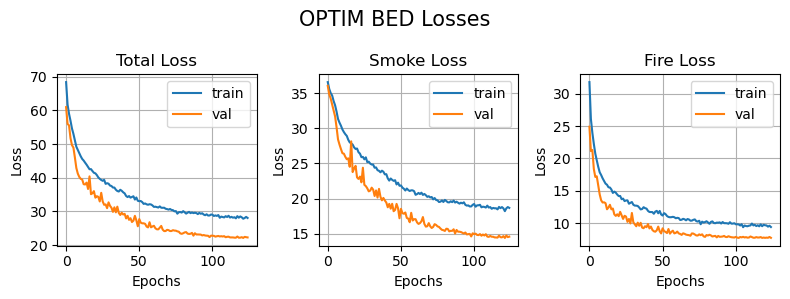

In [20]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()